<a href="https://colab.research.google.com/github/aleng13/phish-and-destroy/blob/main/Phishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initial Configuration**

In [5]:
#Install the Kaggle API client
!pip install -q kaggle

In [6]:
#Move the kaggle.json file to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
#You can download the dataset directly. In a new code cell, run
!kaggle datasets download naserabdullahalam/phishing-email-dataset

Dataset URL: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset
License(s): CC-BY-SA-4.0
  0% 0.00/77.1M [00:00<?, ?B/s]
100% 77.1M/77.1M [00:00<00:00, 1.12GB/s]


In [8]:
#To access the CSV file, you need to unzip the downloaded file
!unzip phishing-email-dataset.zip

Archive:  phishing-email-dataset.zip
  inflating: CEAS_08.csv             
  inflating: Enron.csv               
  inflating: Ling.csv                
  inflating: Nazario.csv             
  inflating: Nigerian_Fraud.csv      
  inflating: SpamAssasin.csv         
  inflating: phishing_email.csv      


In [9]:
import pandas as pd

df = pd.read_csv('phishing_email.csv')

# You can now inspect the first few rows of the DataFrame
print(df.head())

                                       text_combined  label
0  hpl nom may 25 2001 see attached file hplno 52...      0
1  nom actual vols 24 th forwarded sabrae zajac h...      0
2  enron actuals march 30 april 1 201 estimated a...      0
3  hpl nom may 30 2001 see attached file hplno 53...      0
4  hpl nom june 1 2001 see attached file hplno 60...      0


In [10]:
#Which column contains the label (like phishing or not_phishing or 0/1)?
df.columns

Index(['text_combined', 'label'], dtype='object')

# **Preprocessing the Dataset**

In [11]:
'''Preprocessing Steps:
Lowercase the text

Remove punctuation

Remove stopwords (like “the”, “and”, etc.)

Optional: remove numbers

Tokenize and join the cleaned words back to text'''

import re
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords

df = pd.read_csv('phishing_email.csv')

# Download stopwords (only first time)
nltk.download('stopwords')

# Get English stopwords
stop_words = set(stopwords.words('english'))

# Define a text cleaning function
def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Rejoin text
    cleaned_text = ' '.join(words)
    return cleaned_text

# Apply the cleaning function to your email text column
df['cleaned_text'] = df['text_combined'].apply(clean_text)

# Preview cleaned text
df[['text_combined', 'cleaned_text']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text_combined,cleaned_text
0,hpl nom may 25 2001 see attached file hplno 52...,hpl nom may see attached file hplno xls hplno xls
1,nom actual vols 24 th forwarded sabrae zajac h...,nom actual vols th forwarded sabrae zajac hou ...
2,enron actuals march 30 april 1 201 estimated a...,enron actuals march april estimated actuals ma...
3,hpl nom may 30 2001 see attached file hplno 53...,hpl nom may see attached file hplno xls hplno xls
4,hpl nom june 1 2001 see attached file hplno 60...,hpl nom june see attached file hplno xls hplno...


# **Vectorizing The Dataset**

In [12]:
''' Cleaned email text into a machine brain — but since machines don’t understand plain English, we need to vectorize it first.
TfidfVectorizer() → turns text into a matrix of numbers.

fit_transform() → learns vocab and transforms the cleaned text.

train_test_split() → splits the data: 80% to train, 20% to test our model later.'''

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Define the vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the cleaned text
X = vectorizer.fit_transform(df['cleaned_text'])

# Target labels (0 for safe, 1 for phishing)
y = df['label']

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of training data:", X_train.shape)
print("Shape of test data:", X_test.shape)


Shape of training data: (65988, 460787)
Shape of test data: (16498, 460787)


# **Logistic Regression**

In [13]:
'''We’ll train a Logistic Regression model

LogisticRegression → great for binary classification (phish or not)

.fit() → trains the model on your vectors + labels

.predict() → uses the model to detect phishing in new emails

classification_report → shows precision, recall, F1-score = how good your model is'''

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
model = LogisticRegression(max_iter=1000)  # max_iter to make sure it converges

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9846041944478119

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      7935
           1       0.98      0.99      0.99      8563

    accuracy                           0.98     16498
   macro avg       0.98      0.98      0.98     16498
weighted avg       0.98      0.98      0.98     16498



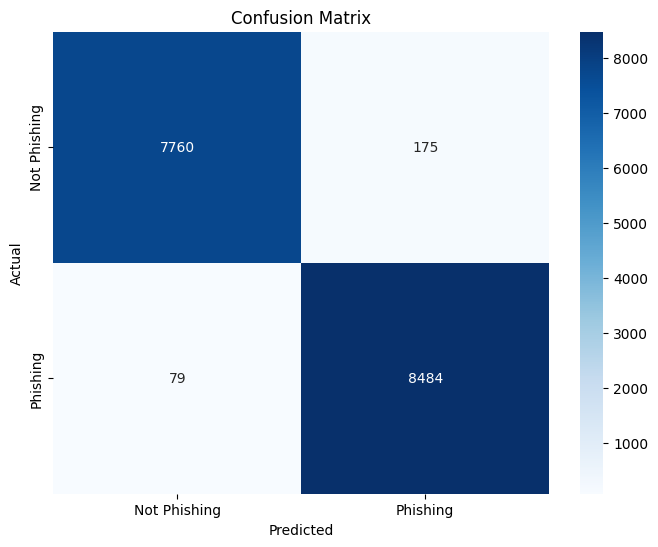


Confusion Matrix (raw counts):
 [[7760  175]
 [  79 8484]]


In [14]:
'''Created a confusion matrix to visualize the model's performance.'''

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Phishing', 'Phishing'],
            yticklabels=['Not Phishing', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nConfusion Matrix (raw counts):\n", cm)

# **Trying to Improving the Accuracy**

In [15]:
'''analyzing the misclassified emails. Here's how we can identify them in your test set using the true labels (y_test) and the predicted labels (y_pred)'''

import pandas as pd

# Assuming your test set features are in X_test and original DataFrame is df
# We need to get the original text corresponding to the test set indices

# Create a DataFrame for the test set predictions
predictions_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred})

# Get the indices of the test set from the original DataFrame
test_indices = y_test.index

# Create a new DataFrame containing the test set data (including original text)
test_df = df.loc[test_indices]

# Combine the predictions with the test set data
misclassified_df = pd.concat([test_df.reset_index(drop=True), predictions_df.reset_index(drop=True)], axis=1)

# Identify False Positives (actual=0, predicted=1)
false_positives_df = misclassified_df[(misclassified_df['actual'] == 0) & (misclassified_df['predicted'] == 1)]
print("\nFalse Positives (Legitimate emails predicted as Phishing):\n")
print(false_positives_df[['text_combined']].head())
print(f"\nNumber of False Positives: {len(false_positives_df)}")

# Identify False Negatives (actual=1, predicted=0)
false_negatives_df = misclassified_df[(misclassified_df['actual'] == 1) & (misclassified_df['predicted'] == 0)]
print("\nFalse Negatives (Phishing emails predicted as Legitimate):\n")
print(false_negatives_df[['text_combined']].head())
print(f"\nNumber of False Negatives: {len(false_negatives_df)}")


False Positives (Legitimate emails predicted as Phishing):

                                         text_combined
48   mail delivery system auixdvasxzygmho02bosmailh...
120  playgroup pictures houston cow parade easy uns...
129  semantics il dominio tempoaspettuale il domini...
260  hours contact information lisa maillet contact...
313  fedmarket uiaregifedmarketcom federal sales tr...

Number of False Positives: 175

False Negatives (Phishing emails predicted as Legitimate):

                                         text_combined
153    tried calling last night missing shouting today
531  sci fi convention hi asked pass might interest...
540                         document document attached
555  remember kaufmann jmr 48036 aim find hype info...
871  expert time travel read einstien would say pro...

Number of False Negatives: 79


In [16]:
'''We'll create some new columns based on things phishing emails often do, like:

Feature	              Description
email_length	        Total number of characters
num_exclamations	    Number of ! characters
num_links	            Count of "http"/"www" keywords
num_uppercase_words	  Suspicious emails often YELL IN ALL CAPS
num_special_chars	    Weird formatting or symbols'''

import numpy as np

# Email length
df['email_length'] = df['cleaned_text'].apply(len)

# Number of exclamation marks
df['num_exclamations'] = df['cleaned_text'].apply(lambda x: x.count('!'))

# Count of links (simple heuristic)
df['num_links'] = df['cleaned_text'].apply(lambda x: x.count('http') + x.count('www'))

# Count of uppercase words
df['num_uppercase_words'] = df['cleaned_text'].apply(lambda x: sum(1 for word in x.split() if word.isupper()))

# Number of special characters (like $, %, etc.)
df['num_special_chars'] = df['cleaned_text'].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in x))


In [17]:
from scipy.sparse import hstack

# Vectorize the cleaned text again
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['cleaned_text'])

# Grab extra features
extra_features = df[['email_length', 'num_exclamations', 'num_links', 'num_uppercase_words', 'num_special_chars']].values

# Combine sparse matrix (TF-IDF) + dense matrix (custom features)
X_combined = hstack([X_tfidf, extra_features])

# Labels
y = df['label']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Load your DataFrame (assuming it's already loaded as 'df')
# If not, make sure you load it here:
# df = pd.read_csv('your_file.csv')

# 1. Vectorize the cleaned text
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['cleaned_text'])

# Ensure X_tfidf is a sparse matrix
X_tfidf_sparse = csr_matrix(X_tfidf)

# 2. Grab extra features (make sure these column names are correct)
extra_features = df[['email_length', 'num_exclamations', 'num_links', 'num_uppercase_words', 'num_special_chars']].values

# 3. Scale the extra (dense) features
scaler = StandardScaler()
scaled_extra_features = scaler.fit_transform(extra_features)

# 4. Combine the sparse TF-IDF features with the scaled dense features
X_combined_scaled = hstack([X_tfidf_sparse, scaled_extra_features])

# 5. Labels
y = df['label']

# 6. Split the data into training and testing sets (using the scaled combined features)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_combined_scaled, y, test_size=0.2, random_state=42
)

# 7. Initialize and train the Logistic Regression model on the scaled data
log_reg_model_scaled = LogisticRegression(max_iter=2000) # Increased max_iter
log_reg_model_scaled.fit(X_train_scaled, y_train)

# 8. Make predictions on the scaled test set
y_pred_scaled = log_reg_model_scaled.predict(X_test_scaled)

# 9. Evaluate the model
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)
print(f"📊 Enhanced Logistic Regression Accuracy (Scaled): {accuracy_scaled:.4f}\n")
print("📋 Classification Report (Scaled):")
print(classification_report(y_test, y_pred_scaled))

📊 Enhanced Logistic Regression Accuracy (Scaled): 0.9845

📋 Classification Report (Scaled):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7935
           1       0.98      0.99      0.99      8563

    accuracy                           0.98     16498
   macro avg       0.98      0.98      0.98     16498
weighted avg       0.98      0.98      0.98     16498



# **Naive Bayes Model**

In [ ]:
''' Trying out with Naive-Bayes Model.

Importing the MultinomialNB classifier — a Naive Bayes model often used for text classification.'''

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Naive Bayes classifier
nb_model = MultinomialNB()

# Train the Naive Bayes model using the training data (X_train = features, y_train = labels)
nb_model.fit(X_train, y_train)

# Use the trained model to predict labels for the test data
y_pred_nb = nb_model.predict(X_test)

# Calculate and print the accuracy score of the Naive Bayes model
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

# Generate and print a detailed classification report (precision, recall, f1-score) for each class
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.97630015759486

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      7935
           1       0.99      0.96      0.98      8563

    accuracy                           0.98     16498
   macro avg       0.98      0.98      0.98     16498
weighted avg       0.98      0.98      0.98     16498



# **Pickle to Save Vectorizer & Trained Model**

In [20]:
import pickle

# Save the vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)
print("✅ TF-IDF Vectorizer saved to tfidf_vectorizer.pkl")

# Save the trained model
with open('phishing_detector_model.pkl', 'wb') as file:
    pickle.dump(log_reg_model_scaled, file)
print("✅ Trained Logistic Regression model saved to phishing_detector_model.pkl")

✅ TF-IDF Vectorizer saved to tfidf_vectorizer.pkl
✅ Trained Logistic Regression model saved to phishing_detector_model.pkl
